# References

https://gym.openai.com/docs/

https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

https://mspries.github.io/jimmy_pendulum.html

https://stackoverflow.com/questions/42787924/why-is-episode-done-after-200-time-steps-gym-environment-mountaincar

https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

# Imports

In [464]:
import gym
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy.control.controlsystem import CrispValueCalculator
import matplotlib.pyplot as plt
import time
import copy
from scipy.linalg import solve_continuous_are as riccati

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# Fuzzy Controller

In [465]:
def to_degree(state):
    out = np.arctan2(state[1],state[0])* (180/np.pi)
    return out

In [466]:
# Fuzzy Inputs & Outputs definition
def create_fuzzy_input_output():
    np.linspace(start=-8, stop=8, num=200)
    degree = ctrl.Antecedent(np.linspace(start=-180, stop=180, num=200), 'degree')
    dot = ctrl.Antecedent(np.linspace(start=-8, stop=8, num=200), 'dot')
    action = ctrl.Consequent(np.linspace(start=-2, stop=2, num=200), 'action')
    
    names = ['VVL', 'VL', 'L', 'M', 'H', 'VH', 'VVH']
    
    dot['L'] = fuzz.trimf(dot.universe, [-8, -8, 0])   
    dot['H'] = fuzz.trimf(dot.universe, [0, 8, 8])
    
    degree['1'] = fuzz.trimf(degree.universe, [0, 45, 90])
    degree['2'] = fuzz.trimf(degree.universe, [90, 135, 180])
    degree['Z'] = fuzz.trimf(degree.universe, [-20, 0, 20]) 
    degree['3'] = fuzz.trimf(degree.universe, [-180, -135, -90])
    degree['4'] = fuzz.trimf(degree.universe, [-90, -45, 0])
    
    
    action.automf(names = names)

    return degree, dot, action


# Define rules
def fuzzy_rules():
    degree, dot, action = create_fuzzy_input_output()

    rules = [
        
        ctrl.Rule(degree['1'] & dot['L'], action['M']),
        ctrl.Rule(degree['1'] & dot['H'], action['VL']),
     
        ctrl.Rule(degree['2'] & dot['L'], action['H']),
        ctrl.Rule(degree['2'] & dot['H'], action['M']),
    
        ctrl.Rule(degree['3'] & dot['L'], action['L']),
        ctrl.Rule(degree['3'] & dot['H'], action['VH']),        
        
        ctrl.Rule(degree['4'] & dot['L'], action['H']),
        ctrl.Rule(degree['4'] & dot['H'], action['M']),
        
        ctrl.Rule(degree['Z'] & degree['1'] & dot['L'], action['M']),
        ctrl.Rule(degree['Z'] & degree['1'] & dot['H'], action['VL']),
        
        ctrl.Rule(degree['Z'] & degree['4'] & dot['L'], action['VH']),
        ctrl.Rule(degree['Z'] & degree['4'] & dot['H'], action['M']),

    ]
    
    return rules


# Controller Design
def controller_design(rules):
    # Define the control system
    speeding_ctrl = ctrl.ControlSystem(rules)
    
    # Simulation object of controlsystem for representation and simulating
    speeding = ctrl.ControlSystemSimulation(speeding_ctrl)
    
    return speeding


rules = fuzzy_rules()
speeding = controller_design(rules)



# Normalizing variables 
def variables_normalizer_denormalizer(state=None , action=None, mode=0):
    state = copy.deepcopy(state)
    factor = 8
    factor_output = 2
    
    if mode==0:
        state[2] = state[2]/factor
        
    elif mode==1:
        action[0] = action[0]*factor_output
        
    return state, action
        

# Final controller agent
def control_agent(state, agent=speeding, mode=0):
    if mode==0:
        degree = to_degree(state)
        dot = state[2]
    elif mode==1:
        degree = state[0]
        dot = state[1]
    elif mode==3:
        degree = state[0]
        dot = state[1]
        
    agent.input['degree'] = degree
    agent.input['dot'] = dot

    agent.compute()              
                
    action = agent.output['action']
    
#     print(f"degree: {degree}, dot:{dot}, action:{action}")

    return [action]

In [467]:
# View membership diagrams

# degree, dot, action = create_fuzzy_input_output()

# degree.view();
# dot.view();
# action.view();
# degree.universe

# Gym Env

In [471]:
# Final function to render to env and take actions
def env_render(env, control_agent, MAX_STEPS=MAX_STEPS, MAX_EPISODES=MAX_EPISODES, render=True):
    
    for episode_counter in range(MAX_EPISODES):
        print(episode_counter)
        state = env.reset()
        total_rewards = 0
        rewards = []
        done = False

        for step_counter in range(MAX_STEPS):
            if render:
                env.render()
                
                
            state, _ = variables_normalizer_denormalizer(state=state ,mode=0)

            action = control_agent(state)
            
            _, action = variables_normalizer_denormalizer(action=action, mode=1)
            
            next_state, reward, done, _ = env.step(action)
            total_rewards += reward
            rewards.append(reward)

            state = next_state
            if done:
                break
                
        print("episode number:{}, total_reward:{:.2f}, step_counter:{}".format(episode_counter, total_rewards, step_counter))
                
        if done:
            env.close()
            break
            
    env.close()
    return rewards, total_rewards

In [472]:
# env = gym.envs.make("Pendulum-v0")
env = gym.make("Pendulum-v0").env

MAX_EPISODES = 1
MAX_STEPS = 500

In [473]:
rewards, total_rewards = env_render(env, control_agent, MAX_STEPS=MAX_STEPS, MAX_EPISODES=MAX_EPISODES, render=True)

0
episode number:0, total_reward:-1107.10, step_counter:499


# Plot rewards

In [474]:
# plot rewatds
def plot_rewards(rewards, limit=False, bottom=-3, top=8, ylabel="Rewards of steps"):
    plt.figure(figsize=(15, 8))
    xticks = len(rewards)
            
    plt.plot(range(1,xticks+1), rewards)
    if limit:
        plt.ylim(top=top)
        plt.ylim(bottom=bottom)
            
    plt.xlabel("Steps")
    plt.ylabel(ylabel)

    plt.show()

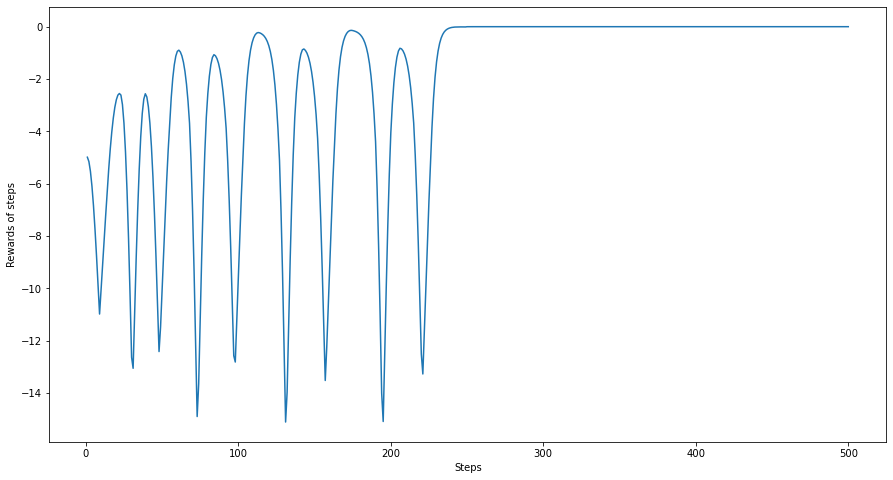

In [475]:
plot_rewards(rewards)

In [476]:
# total_rewards value
total_rewards

-1107.1021297611337